In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns


In [47]:
import sklearn.metrics as mt
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# clustering
from tslearn.clustering import TimeSeriesKMeans


# forecasting 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor


### Table of Contents

* [Data exploration and preprocessing](#chapter1)
    * [Data exploration](#section_1_1)
    * [Data preprocessing](#section_1_2)
        * [Dealing with missing data ](#section_1_2_1)
        * [Removing trend and seasonality](#section_1_2_2)
* [Clustering](#chapter2)
    * [Dynamic time warping(DTW)](#section_2_1)
    * [Clustering with K-means](#section_2_2)
* [Forecasting](#chapter3)
    * [Data transformation](#section_3_1)
    * [Cross-validation hyperparameter tuning](#section_3_2)
* [Results](#chapter4)  

### Data <a class="anchor" id="chapter1"></a>


Outpatient Illness Surveillance - Information on patient visits to health care providers for influenza-like illness is collected through the U.S. Outpatient Influenza-like Illness Surveillance Network (ILINet). ILINet consists of more than 2,900 outpatient healthcare providers in all 50 states, Puerto Rico, the District of Columbia and the U.S. Virgin Islands reporting over 36 million patient visits each year. Each week, approximately 2,000 outpatient healthcare providers around the country report data to CDC on the total number of patients seen and the number of those patients with influenza-like illness (ILI) by age group (0-4 years, 5-24 years, 25-49 years, 50-64 years, and = 65 years). For this system, ILI is defined as fever (temperature of 37.8 Celsius or greater) and a cough and/or a sore throat in the absence of a known cause other than influenza.

### The main goals
The task is to make a forecast of influenza like illness percent in total patients 4 weeks prior, first applying clustering on seasons, and then using fitting algorithms to forecast ILI percent variable.

In [4]:
data = pd.read_csv('ILINet.csv', skiprows=[0])
data.head()

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
0,National,X,1997,40,1.10148,1.21686,179,X,157,205,X,29,570,192,46842
1,National,X,1997,41,1.20007,1.28064,199,X,151,242,X,23,615,191,48023
2,National,X,1997,42,1.37876,1.23906,228,X,153,266,X,34,681,219,54961
3,National,X,1997,43,1.19920,1.14473,188,X,193,236,X,36,653,213,57044
4,National,X,1997,44,1.65618,1.26112,217,X,162,280,X,41,700,213,55506


In [5]:
data.describe()

,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 5-24,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
count,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1.235000e+03
mean,2009.075304,26.548988,1.764699,1.692986,2798.045344,4041.459919,705.663158,11003.727126,1335.445344,5.352731e+05
std,6.846310,15.166493,1.424744,1.334128,3085.393407,5580.554873,1011.817077,14216.549579,837.177605,4.012974e+05
min,1997.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2003.000000,13.000000,0.885041,0.893666,623.000000,762.500000,140.000000,2212.000000,614.000000,1.684615e+05
50%,2009.000000,26.000000,1.337900,1.273860,1958.000000,2359.000000,378.000000,6741.000000,1362.000000,5.448270e+05
75%,2015.000000,40.000000,2.237355,2.090120,3811.000000,4933.000000,775.000000,14309.000000,1933.000000,7.846280e+05
max,2021.000000,53.000000,7.715100,7.780900,24097.000000,45513.000000,6986.000000,111361.000000,3459.000000,1.722368e+06


In [6]:
# cleaning data
data = data.drop(['REGION TYPE','REGION','% WEIGHTED ILI'], axis=1)
data = data.replace('X', 0)

In [7]:
ind = data[(data["YEAR"]==2017) & (data["WEEK"]==39)].index[0]
data = data[:ind+1]
data.rename(columns={'%UNWEIGHTED ILI': 'ILI percent'}, inplace=True)
data = data.astype('float')

In [8]:
# creating variable SEASON
pd.options.mode.chained_assignment = None
season = 0
s_vector = []
for i in range(len(data.index)):
    if data.iloc[i]["WEEK"]==40:
        season+=1
        s_vector.append(season)
    else:
        s_vector.append(season)
data['SEASON']=s_vector        

### Data exploration<a class="anchor" id="section_1_1"></a>
First I tried to see how variables behave in terms of time series data. My guess is that exploration of all variables by themselves doesn’t make a lot of sense in this case, because all variables are tied to the time stamps. We can see that variables *TOTAL PATIENTS*, *ILI TOTAL* and variables by age all increasing with years. It can be because it became much easier to collect data on patients. Some variables have a lot of missing data, and missing data are in chunks. This means that this data is not MCAR(missing completely at random) nut MAR(missing at random), which means that missing data have a meaning, but it is not tied with our prediction variable. We can see that, like for patients of ages 25-49 the data supposedly was not collected for couple of years. Also, on first years data was not collected for the weeks of summer, so there is missing data for all variable on these periods. 

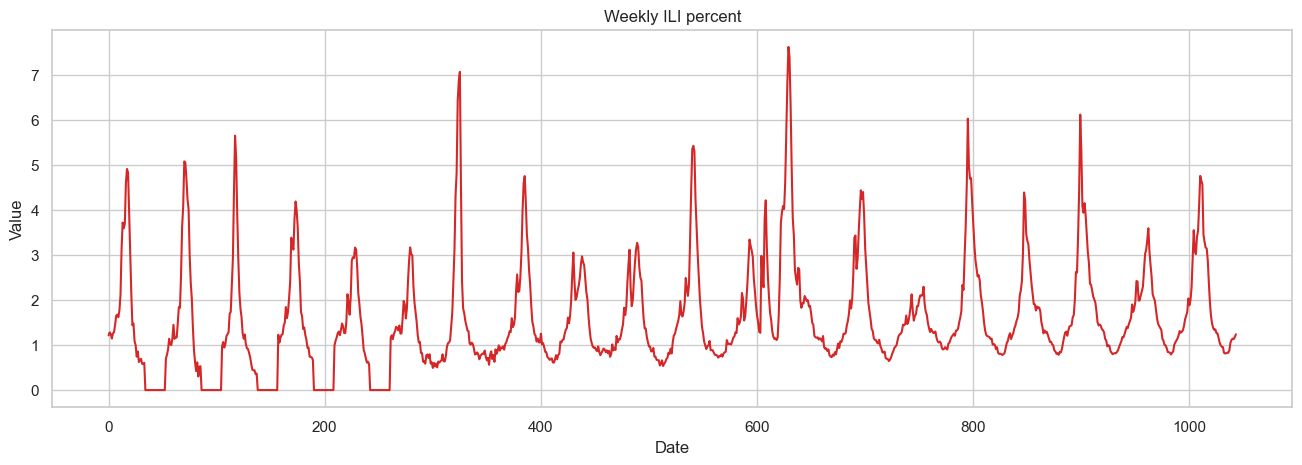

In [9]:
# ploting variable ILI percent 
sns.set_theme(style="whitegrid")
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(data, x=data.index, y=data['ILI percent'], title='Weekly ILI percent') 

### Patients with influenza like illness by age

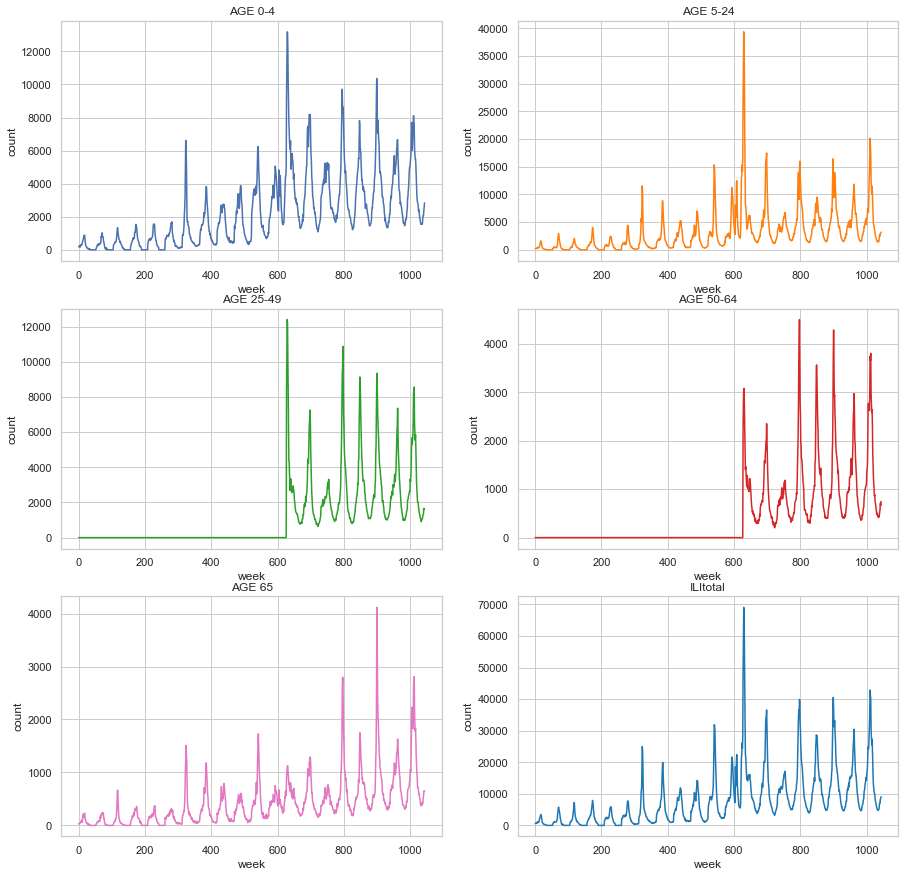

In [10]:
fig, axs = plt.subplots(3, 2,figsize=(15,15))
axs[0, 0].plot(range(len(data.index)),data['AGE 0-4'])
axs[0, 0].set_title('AGE 0-4')
axs[0, 1].plot(range(len(data.index)),data['AGE 5-24'], 'tab:orange')
axs[0, 1].set_title('AGE 5-24')
axs[1, 0].plot(range(len(data.index)),data['AGE 25-49'], 'tab:green')
axs[1, 0].set_title('AGE 25-49')
axs[1, 1].plot(range(len(data.index)),data['AGE 50-64'], 'tab:red')
axs[1, 1].set_title('AGE 50-64')
axs[2, 0].plot(range(len(data.index)),data['AGE 65'], 'tab:pink')
axs[2, 0].set_title('AGE 65')
axs[2, 1].plot(range(len(data.index)),data['ILITOTAL'], 'tab:blue')
axs[2, 1].set_title('ILItotal')

for ax in axs.flat:
    ax.set(xlabel='week', ylabel='count')


plt.show()

### Influenza like illness percent from total patients by season

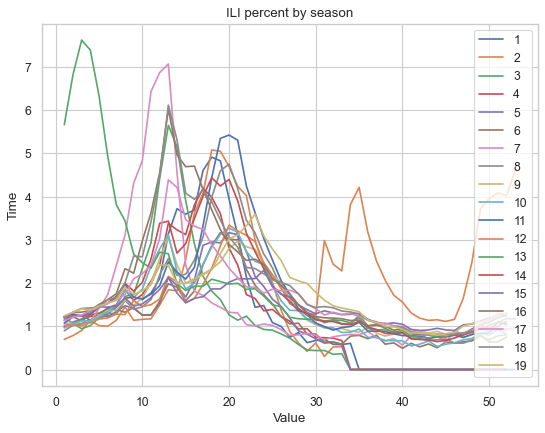

In [11]:
figure(figsize=(8, 6), dpi=80)
for i in range(1,20):
    d = data[data['SEASON']==i]       
    plt.plot(range(1, len(d['ILI percent'])+1), d['ILI percent'], label=str(i))

plt.legend(loc="upper right")
plt.legend(loc="upper right")
plt.xlabel('Value')
plt.ylabel('Time')
plt.title('ILI percent by season')
plt.show()
plt.show() 

In [12]:
# using only data
d = data[data['SEASON'].between(6, 19, inclusive=True)]
mask = d['SEASON'].isin([12, 13])
d = d[~mask]

### Data preprocessing<a class="anchor" id="section_1_2"></a>

### Dealing with missing data <a class="anchor" id="section_1_2_1"></a>
Simple ways of dealing with missing data I found not very fitting in this case, like filling missing values with mean or median, because values are changing over time, and like for *ILI percent* on summer weeks , it will not make a lot of sense to have high ILI percent. I’ve seen in some cases for time series values are filled with previos values if such exists.  So in this case I tried to take last value for each season and fill the rest of missing values with this values but I also added some noise to it, using random normal distribution with arbitrary variance. 

### Before filling missing values

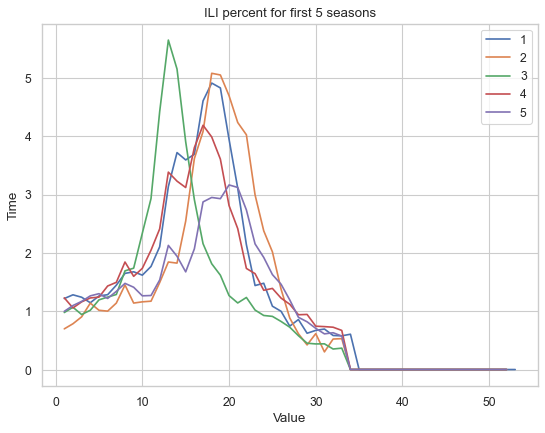

In [13]:
figure(figsize=(8, 6), dpi=80)
for i in range(1,6):
    d = data[data['SEASON']==i]       
    plt.plot(range(1, len(d['ILI percent'])+1), d['ILI percent'], label=str(i))
    
plt.legend(loc="upper right")
plt.xlabel('Value')
plt.ylabel('Time')
plt.title('ILI percent for first 5 seasons')
plt.show()

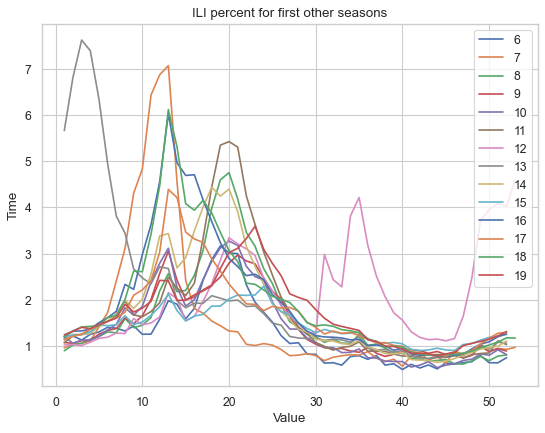

In [14]:
figure(figsize=(8, 6), dpi=80)
for i in range(6,20):
    d = data[data['SEASON']==i]       
    plt.plot(range(1, len(d['ILI percent'])+1), d['ILI percent'], label=str(i))
    
plt.legend(loc="upper right")
plt.xlabel('Value')
plt.ylabel('Time')
plt.title('ILI percent for first other seasons')
plt.show()

In [15]:
# calculating ages proportion

d = data[data['SEASON'].between(1, 5, inclusive=True)]
d = d[d['ILI percent']!=0]
d = d[['AGE 0-4','AGE 25-49','AGE 25-64','AGE 5-24','AGE 50-64','AGE 65','ILITOTAL']]
s = d.sum(axis = 0, skipna = True)
prop_row = np.array(s[:-1])/s[-1]

In [16]:
# filling missing values for sesons 1-5 with normal distributed ILI percent

np.random.seed(123)

for i in range(1,6):
    # remouving unusual seasons 
    df = data[data['SEASON'].between(6, 19, inclusive=True)]
    mask = df['SEASON'].isin([12, 13])
    df = df[~mask]
    k = range(21,40)
    d = data[data['SEASON']==i]
    ind = d['WEEK'].isin(k)
    d1 = d[ind]
    d2 = d[~ind]
    ili_per = np.random.normal(d[d['WEEK']==20]['ILI percent'], 0.1, len(k))
    prop_pat = np.random.normal(d[d['WEEK']==20]['TOTAL PATIENTS'], 2000 , len(k))
    ili_pat = np.round(prop_pat*(ili_per/100))
    n_prov = np.random.normal(d[d['WEEK']==20]['NUM. OF PROVIDERS'], 10 , len(k))
    ind = d1[d1['WEEK']==21].index[0]
    data.loc[ind:(ind-1)+len(k), ['TOTAL PATIENTS']] = prop_pat.tolist()
    data.loc[ind:(ind-1)+len(k), ['NUM. OF PROVIDERS']] = n_prov.tolist()
    data.loc[ind:(ind-1)+len(k):, ['ILITOTAL']] = ili_pat.tolist()
    data.loc[ind:(ind-1)+len(k), ['ILI percent']] = ili_per
    # based on calculated value of 
    for j in range(ind,ind+len(k)):
        np_ar = np.round(data['ILITOTAL'][j]*prop_row)
        data.loc[j, ['AGE 0-4','AGE 25-49','AGE 25-64','AGE 5-24','AGE 50-64','AGE 65']] = np_ar.tolist()

### After filling missing values

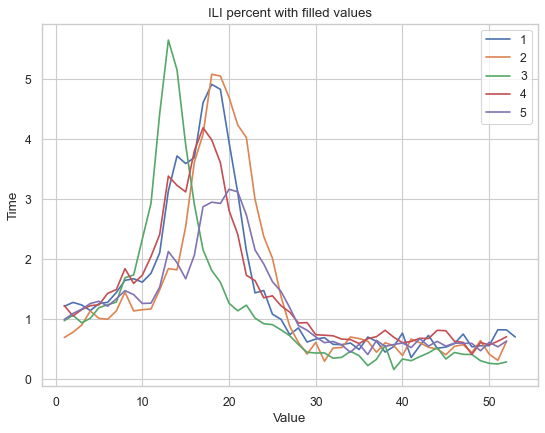

In [17]:
figure(figsize=(8, 6), dpi=80)
for i in range(1,6):
    d = data[data['SEASON']==i]       
    plt.plot(range(1, len(d['ILI percent'])+1), d['ILI percent'], label=str(i))

plt.legend(loc="upper right")
plt.legend(loc="upper right")
plt.xlabel('Value')
plt.ylabel('Time')
plt.title('ILI percent with filled values')
plt.show()
plt.show()    

In [18]:
d = data[data['AGE 25-49']!=0]
prop1 = np.mean(d['AGE 25-49']/d['ILITOTAL'])

In [19]:
d = data[data['AGE 50-64']!=0]
prop2 = np.mean(d['AGE 25-49']/d['ILITOTAL'])

In [20]:
d = data[data['AGE 25-49']==0]
age25 = d['ILITOTAL']*prop1
age50 = d['ILITOTAL']*prop2

In [21]:
data.loc[0:d.index[-1], ['AGE 25-49']] = age25
data.loc[0:d.index[-1], ['AGE 50-64']] = age25

### Removing trend and seasonality<a class="anchor" id="section_1_2_2"></a>
For forecast I used only variables *WEEK*, *pred*, that is variables with predicted clusters from K-means, and *ILI percent*. At first I wanted to add other variables in my models, but the variables *TOTAL PATIENTS* are increasing over time, in time series terms it has a trend. I tied to remove trend and seasonality at first, but it didn’t help the prediction, and in some cases made it worse, so I removed it completely. But I left this code to show my. Attempt to use it. 

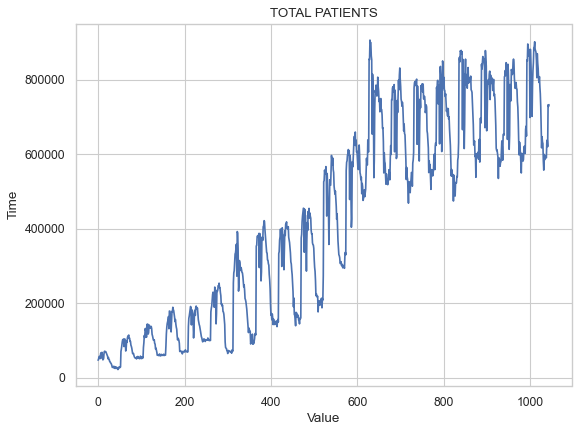

In [22]:
figure(figsize=(8, 6), dpi=80)
plt.plot(range(len(data.index)),data['TOTAL PATIENTS'])
plt.xlabel('Value')
plt.ylabel('Time')
plt.title('TOTAL PATIENTS')
plt.show()

In [23]:
def detrending(data, column):
    log = pd.DataFrame(data[column].apply(lambda x : np.log(x)))

    pow_rolled_detrended = log - log.shift()

    pow_rolled_detrended_diff = pow_rolled_detrended - pow_rolled_detrended.shift()
    return pow_rolled_detrended_diff

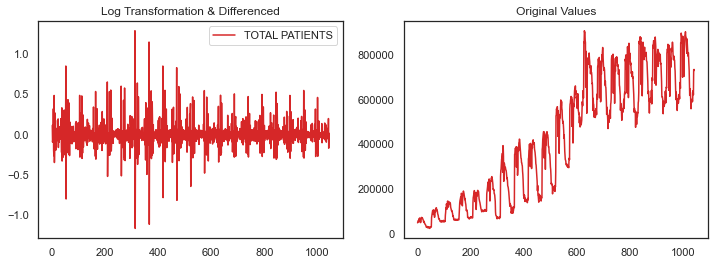

In [24]:
# removing trend and sesionality 
sns.set_style("white")
d1 = data['TOTAL PATIENTS']
d2 = detrending(data,'TOTAL PATIENTS')
ax1 = plt.subplot(121)
d2.plot(figsize=(12,4),color="tab:red", title="Log Transformation & Differenced", ax=ax1);
ax2 = plt.subplot(122)
d1.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

In [25]:
data['TP detrend'] = detrending(data,'TOTAL PATIENTS')
data['ILIT detrend'] = detrending(data,'ILITOTAL')
data = data.replace(np.nan, 0)

In [26]:
ind = data[(data["YEAR"]==2015) & (data["WEEK"]==40)].index[0]
data_train_f = data[:ind]
data_test_f  = data[ind:ind+52*2]

## Clustering <a class="anchor" id="chapter2"></a>


### Dynamic Time Warping<a class="anchor" id="section_2_1"></a>
For measuring distance between two series, I used  dynamic time warping. In time series analysis, dynamic time warping (DTW) is one of the algorithms for measuring similarity between two temporal sequences, which may vary in speed. The optimal match is denoted by the match that satisfies all the restrictions and the rules and that has the minimal cost, where the cost is computed as the sum of absolute differences, for each matched pair of indices, between their values. 

The sequences are "warped" non-linearly in the time dimension to determine a measure of their similarity independent of certain non-linear variations in the time dimension. This sequence alignment method is often used in time series classification. Although DTW measures a distance-like quantity between two given sequences, it doesn't guarantee the triangle inequality to hold.

Below is the example of DTW between two seasons. 

In [27]:
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



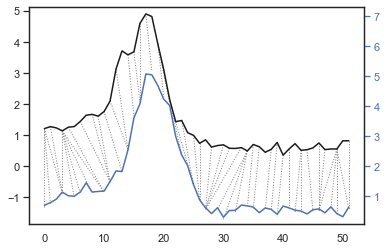

<AxesSubplot:>

In [28]:
one = data_train_f[data_train_f['SEASON']==1]['ILI percent'][:52]
two = data_train_f[data_train_f['SEASON']==2]['ILI percent'][:52]
alignment = dtw(one, two, keep_internals=True)

sns.set_style("white")
alignment.plot(type="twoway",offset=-2)

### Clustering with K-means<a class="anchor" id="section_2_2"></a>
First I used K-means clustering with DTW distance for different k value, and by using elbow method determined that k=5 will be optimal. 
Than I applied K-means with chosen k, to make clusters of train data. Below we can see plot with different clusters of seasons.  

In [29]:
l = []
for i in range(1,19):
    l.append(data_train_f[data_train_f['SEASON']==i]['ILI percent'][:52])

n = np.concatenate(l)
n = n.reshape(18, 52, 1)

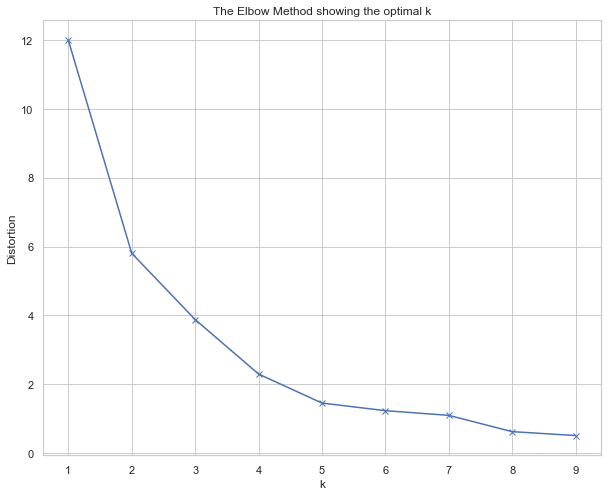

In [30]:
distortions = []
K = range(1,10)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=5, max_iter_barycenter=5,random_state=0)
    km.fit(n)
    distortions.append(km.inertia_)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [31]:
km = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=5, max_iter_barycenter=5,random_state=0)
pred = km.fit_predict(n)

In [32]:
for i in range(0,18):
    ind = data_train_f.index[data_train_f['SEASON']==i+1].tolist()
    data_train_f.loc[ind,['pred']] = pred[i]

In [33]:
data_train_f['pred'] = data_train_f['pred'].astype("category")

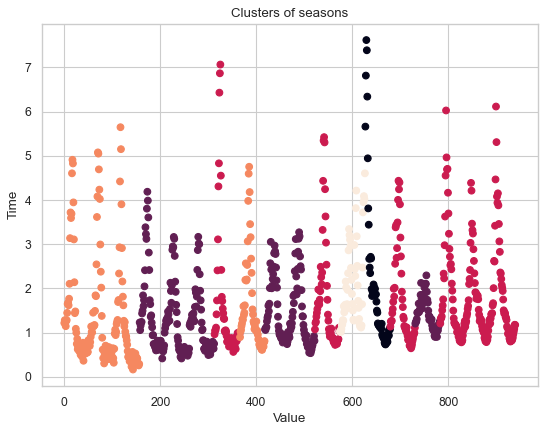

In [34]:
figure(figsize=(8, 6), dpi=80)
plt.scatter(range(940),data_train_f['ILI percent'], c=data_train_f['pred'])
plt.xlabel('Value')
plt.ylabel('Time')
plt.title('Clusters of seasons')
plt.show()

## Forecasting <a class="anchor" id="chapter3"></a>

### Data transformation<a class="anchor" id="section_3_1"></a>

By researching suitable algorithms for time series prediction, I found that most of them need a lot of previos data to make a prediction and they mostly rely on one variable. I thought that these methods are not very useful in this case, because we needed to use k-means clusters to help the prediction. So I tried to transform the data. First I applied clustering on test data to add clusters. Then I used function that I found on the internet to transform time series data for supervised algorithms by shifting data to add to each row values from previous and future weeks as well. Then I removed variables for future weeks, besides *ILI percent* of forth week, so we can use it as y variable. 

In [35]:
l = []
for i in range(19,21):
    l.append(data_test_f[data_test_f['SEASON']==i]['ILI percent'][:52])

n = np.concatenate(l)
n = n.reshape(2, 52, 1)

In [36]:
pred = km.predict(n)

data_test_f['pred'] = np.concatenate([np.repeat(pred[0], 52),np.repeat(pred[1], 52)])
data_test_f['pred'] = data_test_f['pred'].astype("category")

In [37]:
 def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [38]:
# ctreating dataset with 4 weeks step and 
n_steps = 4
n_pred = 4
raw = data_train_f[['SEASON','WEEK','pred','ILI percent']]
values = raw.values
data_sv = series_to_supervised(values, n_steps, n_pred)
data_sv.head()

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),...,var3(t+1),var4(t+1),var1(t+2),var2(t+2),var3(t+2),var4(t+2),var1(t+3),var2(t+3),var3(t+3),var4(t+3)
4,1.0,40.0,3.0,1.21686,1.0,41.0,3.0,1.28064,1.0,42.0,...,3.0,1.28275,1.0,46.0,3.0,1.44579,1.0,47.0,3.0,1.64796
5,1.0,41.0,3.0,1.28064,1.0,42.0,3.0,1.23906,1.0,43.0,...,3.0,1.44579,1.0,47.0,3.0,1.64796,1.0,48.0,3.0,1.67517
6,1.0,42.0,3.0,1.23906,1.0,43.0,3.0,1.14473,1.0,44.0,...,3.0,1.64796,1.0,48.0,3.0,1.67517,1.0,49.0,3.0,1.61739
7,1.0,43.0,3.0,1.14473,1.0,44.0,3.0,1.26112,1.0,45.0,...,3.0,1.67517,1.0,49.0,3.0,1.61739,1.0,50.0,3.0,1.76632
8,1.0,44.0,3.0,1.26112,1.0,45.0,3.0,1.28275,1.0,46.0,...,3.0,1.61739,1.0,50.0,3.0,1.76632,1.0,51.0,3.0,2.10398


In [39]:
data_sv[['var3(t-4)','var3(t-3)','var3(t-2)','var3(t-1)']] = data_sv[['var3(t-4)','var3(t-3)','var3(t-2)','var3(t-1)']].astype(int).astype("category")
data_sv[['var2(t-4)','var2(t-3)','var2(t-2)','var2(t-1)']] = data_sv[['var2(t-4)','var2(t-3)','var2(t-2)','var2(t-1)']].astype(int).astype("category")

In [40]:
X = data_sv.iloc[:,:n_steps*len(raw.columns)]
groups = X['var1(t-1)']
X = X.drop(['var1(t-4)','var1(t-3)','var1(t-2)', 'var1(t-1)'], axis=1)
y = data_sv.iloc[:,-1]
X.head()

,var2(t-4),var3(t-4),var4(t-4),var2(t-3),var3(t-3),var4(t-3),var2(t-2),var3(t-2),var4(t-2),var2(t-1),var3(t-1),var4(t-1)
4,40,3,1.21686,41,3,1.28064,42,3,1.23906,43,3,1.14473
5,41,3,1.28064,42,3,1.23906,43,3,1.14473,44,3,1.26112
6,42,3,1.23906,43,3,1.14473,44,3,1.26112,45,3,1.28275
7,43,3,1.14473,44,3,1.26112,45,3,1.28275,46,3,1.44579
8,44,3,1.26112,45,3,1.28275,46,3,1.44579,47,3,1.64796


In [41]:
raw_test = data_test_f[['SEASON','WEEK','pred','ILI percent']]
values = raw_test.values
data_sv_test = series_to_supervised(values, n_steps, n_pred)

data_sv_test[['var3(t-4)','var3(t-3)','var3(t-2)','var3(t-1)']] = data_sv_test[['var3(t-4)','var3(t-3)','var3(t-2)','var3(t-1)']].astype(int).astype("category")
data_sv_test[['var2(t-4)','var2(t-3)','var2(t-2)','var2(t-1)']] = data_sv_test[['var2(t-4)','var2(t-3)','var2(t-2)','var2(t-1)']].astype(int).astype("category")

X_test = data_sv_test.iloc[:,:n_steps*len(raw_test.columns)]
X_test = X_test.drop(['var1(t-4)','var1(t-3)','var1(t-2)', 'var1(t-1)'], axis=1)
y_test = data_sv_test.iloc[:,-1]

### Cross-validation hyperparameter tuning<a class="anchor" id="section_3_2"></a>
Then I divided  the data for cross-validation by seasons, and than I applied supervised algorithms one at the time and tried to find best hyperparameters for each model. 

In [42]:
logo = LeaveOneGroupOut()

In [48]:
def get_models(models=dict()):
    # linear models
    models['lr'] = LinearRegression()
    models['lasso'] = Lasso()
    models['ridge'] = Ridge()
    models['en'] = ElasticNet()
    # non-linear models
    models['knn'] = KNeighborsRegressor()
    models['cart'] = DecisionTreeRegressor()
    models['svmr'] = SVR()
    # ensemble models
    models['ada'] = AdaBoostRegressor()
    models['bag'] = BaggingRegressor()
    models['rf'] = RandomForestRegressor()
    models['et'] = ExtraTreesRegressor()
    models['gbm'] = GradientBoostingRegressor()
    return models

In [49]:
models = get_models() 
param_grid = {'lasso':{'alpha': np.arange(0.01, 0.7, 0.01)}, 
              'ridge':{'alpha': np.arange(0.5, 1, 0.01)},
              'en':{'alpha': np.arange(0.01, 0.7, 0.01)},
              'knn':{'n_neighbors': np.arange(1, 25)},
              'cart':{'max_depth':np.arange(1,15),'min_samples_leaf':[1, 5, 10, 25, 50, 100]},
              'svmr':{'C': [1, 100, 1000, 2000, 5000],'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]},
              'ada': {'n_estimators':[5,10,25,50], 'learning_rate':[0.01, 0.1, 0.2, 0.5, 0.7]},
              'bag':{'n_estimators':[5,10,25,50,100], 'max_samples' : [10,25,50,100,500]},
              'rf':{'n_estimators':[10,25,50,100],'max_depth':np.arange(1,15),'min_samples_leaf':[1, 5, 10, 25]}, 
              'et':{'n_estimators':[100,250,500],'max_depth':np.arange(1,10),'min_samples_leaf':[1, 5, 10, 25]},
              'gbm':{'n_estimators':[50,100,250],'max_depth':np.arange(1,15),'min_samples_leaf':[5, 10, 25, 50]}}

In [51]:
s = str(list(models.values())).replace('[','').replace(']','').replace('()','')
print('Models used are ' + s)

Models used are LinearRegression, Lasso, Ridge, ElasticNet, KNeighborsRegressor, DecisionTreeRegressor, SVR, AdaBoostRegressor, BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor


In [52]:
np.random.seed(123)

est = []
for i in models.keys():
    if i!='lr':
        mod = models[i]
        param_grid_i = param_grid[i]
        mod_gscv = GridSearchCV(mod, param_grid_i, cv=logo.split(X,y,groups))
        mod_gscv.fit(X, y)
        param = mod_gscv.best_params_
        est.append(param)
        print( 'R2 of model ' + i + ' with parametrs ' + str(param).replace('{', '').replace('}', '') + ' is ' + str(round(mod_gscv.best_score_, 4)))
    else:
        mod = models[i]
        print( 'R2 of ' + i + ' model is ' + str(round(np.mean(cross_val_score(mod, X, y, cv=logo.split(X,y,groups))), 4)))
              

R2 of lr model is 0.5779
R2 of model lasso with parametrs 'alpha': 0.01 is 0.5768
R2 of model ridge with parametrs 'alpha': 0.9900000000000004 is 0.5783
R2 of model en with parametrs 'alpha': 0.01 is 0.5779
R2 of model knn with parametrs 'n_neighbors': 8 is 0.5883
R2 of model cart with parametrs 'max_depth': 6, 'min_samples_leaf': 10 is 0.6308
R2 of model svmr with parametrs 'C': 5000, 'gamma': 0.0001 is 0.6738
R2 of model ada with parametrs 'learning_rate': 0.2, 'n_estimators': 50 is 0.6325
R2 of model bag with parametrs 'max_samples': 500, 'n_estimators': 50 is 0.7305
R2 of model rf with parametrs 'max_depth': 9, 'min_samples_leaf': 1, 'n_estimators': 10 is 0.7374
R2 of model et with parametrs 'max_depth': 9, 'min_samples_leaf': 1, 'n_estimators': 250 is 0.7108
R2 of model gbm with parametrs 'max_depth': 6, 'min_samples_leaf': 25, 'n_estimators': 100 is 0.7652


In [53]:
def mape(y_pred, y_true):
    res = np.max(np.abs(y_true - y_pred) / y_true) * 100
    return res

def rmspe(y_pred, y_true):
    res = (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))) * 100
    return res

def hr(y_pred, y_true):
    res = (sum(np.sign(np.array(y_pred[1:])-np.array(y_pred[:-1]))==np.sign(np.array(y_true[1:])-np.array(y_true[:-1])))/(len(y_pred)-1))*100
    return res


In [54]:
scores = {}
base = data_train_f.groupby('WEEK')['ILI percent'].mean()
y_pred = []
for i in range(7,len(data_test_f)):
    week = data_test_f.iloc[i]['WEEK']
    y_pred.append(base[week])     
r2 = mt.r2_score(y_test, y_pred)
rmse = mt.mean_squared_error(y_test, y_pred, squared =False)
v_mape = mape(y_pred, y_test)
v_rmspe = rmspe(y_pred, y_test)
v_hr = hr(y_pred, y_test)
scores['Baseline predictor'] = [r2, rmse, v_mape, v_rmspe, v_hr]

In [55]:
models_est = list(models.keys())[1:]
for i in models.keys():
    if i!='lr':
        mod = models[i]
        mod.set_params(**est[models_est.index(i)])
        mod.fit(X,y)
        y_pred = mod.predict(X_test)
        r2 = mt.r2_score(y_test, y_pred)
        rmse = mt.mean_squared_error(y_test, y_pred, squared =False)
        v_mape = mape(y_pred, y_test)
        v_rmspe = rmspe(y_pred, y_test)
        v_hr = hr(y_pred, y_test)
        s = str(models[i]).replace('()', '')
        scores[s] = [r2, rmse, v_mape, v_rmspe, v_hr]
    else:
        mod = models[i]
        mod.fit(X,y)
        y_pred = mod.predict(X_test)
        r2 = mt.r2_score(y_test, y_pred)
        rmse = mt.mean_squared_error(y_test, y_pred, squared =False)
        v_mape = mape(y_pred, y_test)
        v_rmspe = rmspe(y_pred, y_test)
        v_hr = hr(y_pred, y_test)
        s = str(models[i]).replace('()', '')
        scores[s] = [r2, rmse, v_mape, v_rmspe, v_hr]

## Results<a class="anchor" id="chapter4"></a>
Finally I used applied models with chosen hyperparameters on the test data.

In [59]:
d = pd.DataFrame.from_dict(scores, orient='index',columns=['r2', 'rmse', 'mape', 'rmspe','hr'])
d

,r2,rmse,mape,rmspe,hr
Baseline predictor,0.624530,0.598463,46.922518,23.922643,79.166667
LinearRegression,0.688663,0.544960,55.202540,20.405304,57.291667
Lasso(alpha=0.01),0.689213,0.544479,56.149660,20.347918,62.500000
Ridge(alpha=0.9900000000000004),0.688882,0.544768,55.332992,20.390781,58.333333
ElasticNet(alpha=0.01),0.688499,0.545104,56.072062,20.386313,62.500000
KNeighborsRegressor(n_neighbors=8),0.756045,0.482397,42.672113,20.446281,77.083333
"DecisionTreeRegressor(max_depth=6, min_samples_leaf=10)",0.700360,0.534625,49.441684,20.308608,21.875000
"SVR(C=5000, gamma=0.0001)",0.794812,0.442411,53.018519,16.258239,64.583333
AdaBoostRegressor(learning_rate=0.2),0.749832,0.488501,51.757547,20.634401,53.125000
"BaggingRegressor(max_samples=500, n_estimators=50)",0.788260,0.449418,51.020290,16.948041,72.916667
